# Import Stuff

In [1]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from owslib.wms import WebMapService
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import numpy as np
import pandas as pd
from PIL import Image
import io
from scipy.stats import probplot
from scipy.stats import norm, lognorm
import geopandas as gpd
from sklearn.mixture import GaussianMixture
import probscale
import seaborn
clear_bkgd = {'axes.facecolor':'none', 'figure.facecolor':'none'}
seaborn.set(style='ticks', context='talk', color_codes=True, rc=clear_bkgd)

# Functions

In [2]:
# RMS Fit calculation
def calculate_rms(x, x_mod):
    residuals = x - x_mod
    rms = np.sqrt(np.mean(residuals ** 2))
    return rms

# R-squared calculation
def calculate_r_squared(x, x_mod):
    ss_residual = np.sum((x - x_mod) ** 2)   # Sum of squared residuals
    ss_total = np.sum((x - np.mean(x)) ** 2)  # Total sum of squares
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

# Import CSV Data

In [3]:
data_SP_CO2 = pd.read_csv("Rangitoto_SP_Co2_forPlotting.csv") # all data

## Plotting

The code input is hidden thanks to the guide from [here.](https://discourse.jupyter.org/t/difficulty-editing-metadata-tags-to-hide-cell-inputs-and-outputs/14973/4)

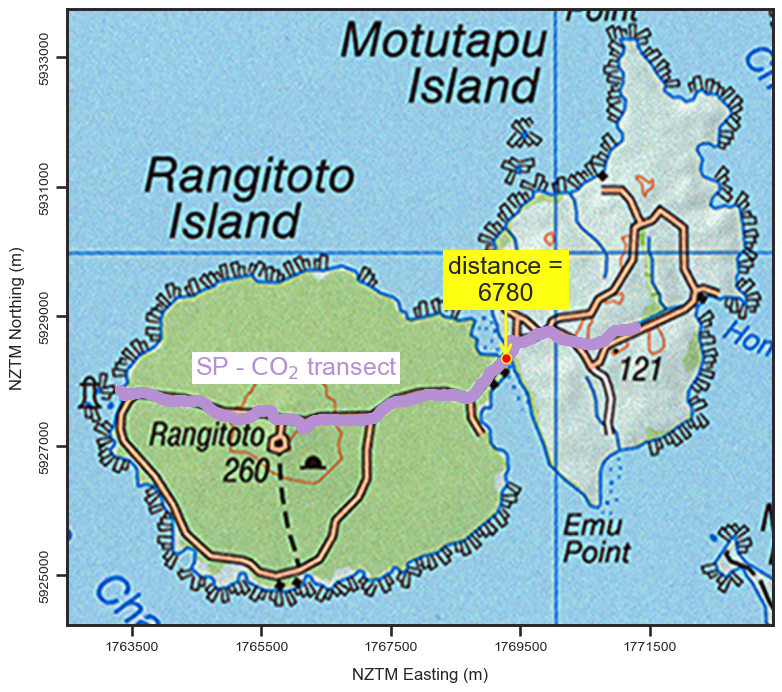

In [4]:
# Create figure and projection
# Setup WMS
wms = WebMapService('https://gis.gns.cri.nz/server/services/basemaps/topo250/ImageServer/WMSServer', version='1.1.1')

fig, ax = plt.subplots(figsize=(12, 8),
                       subplot_kw=dict(projection=ccrs.epsg(2193)))

# Get WMS image
img = wms.getmap(layers=['topo250'],
                 srs='EPSG:2193',
                 bbox=(1762495, 5924225, 1773400, 5933745),
                 size=(1200, 800),
                 format='image/png')

# Convert to image
img = Image.open(io.BytesIO(img.read()))
ax.imshow(img, extent=[1762495, 1773400, 5924225, 5933745], 
          transform=ccrs.epsg(2193), alpha=1.0)

# Plot points and rest of the code remains the same
mask = data_SP_CO2['DISTANCE'] != 6780
ax.scatter(data_SP_CO2[mask]['X_NZTM'], data_SP_CO2[mask]['Y_NZTM'],
          transform=ccrs.epsg(2193),
          color='xkcd:pale purple', edgecolor='xkcd:pale purple',
          linewidth=1, s=50, zorder=3)
ax.text(1766040, 5928200, r'SP - $\mathrm{CO_2}$ transect', color='xkcd:pale purple', verticalalignment='center',
        horizontalalignment='center', bbox=dict(facecolor='xkcd:white', edgecolor='None', alpha=1, pad=2))

mask_6780 = data_SP_CO2['DISTANCE'] == 6780
ax.scatter(data_SP_CO2[mask_6780]['X_NZTM'], data_SP_CO2[mask_6780]['Y_NZTM'],
          transform=ccrs.epsg(2193),
          color='red', edgecolor='xkcd:yellow',
          linewidth=1, s=50, zorder=4)

for idx, row in data_SP_CO2[mask_6780].iterrows():
    ax.annotate('distance =\n6780',
                xy=(row['X_NZTM'], row['Y_NZTM']),
                xytext=(row['X_NZTM'], row['Y_NZTM']+900),
                bbox=dict(facecolor='xkcd:yellow', edgecolor='xkcd:yellow', alpha=1, pad=3),
                textcoords='data',
                arrowprops=dict(arrowstyle='->',
                                color='xkcd:yellow',
                                lw=2.0, shrinkA=0, shrinkB=0),
                transform=ccrs.epsg(2193),
                ha='center', va='baseline')

# Replace the existing tick configuration with:
ax.set_xticks(np.arange(1763500, 1773000, 2000))
ax.set_yticks(np.arange(5925000, 5933700, 2000))

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.ticklabel_format(style='plain')
ax.tick_params(axis='y', labelrotation=90, labelsize=10, length=8)
for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')
ax.tick_params(axis='x', labelsize=10, length=8)
ax.set_xlabel('NZTM Easting (m)', fontsize=12, labelpad=10)
ax.set_ylabel('NZTM Northing (m)', fontsize=12, labelpad=10)

# Optional: Add spines if you want a border
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

# delete the variables
del wms, img

## Group the Data

From the map above, we know that Rangitoto - Motutapu divide is located at `DISTANCE == 6780` mark.

In [5]:
data_SP_rangiOnly = data_SP_CO2[data_SP_CO2['DISTANCE'] <= 6780.0].reset_index(drop=True).copy() # Rangitoto only
data_SP_motuOnly = data_SP_CO2[data_SP_CO2['DISTANCE'] > 6780.0].reset_index(drop=True).copy() # Motutapu only

The instrument used for Rangitoto $\mathrm{CO_2}$ gas flux measurement was a portable gas flux meter developed by [West Systems S.r.l](https://www.westsystems.eu/en/instrumentation/diffuse-emission/portable-fluxmeter.html), fitted with an infrared (IR) spectrometer ([LICOR 850 CO₂ detector](https://www.catec.nl/uploads/pdf/LI830-850%20brochure_2512.pdf), with a full scale of the detector used of 20,000 ppm, with an accuracy $< 1.5\%$ of reading and zero drift $< 0.15\;\mathrm{ppm/^{\circ}C}$) and a [Type-B accumulation chamber](https://www.westgroupnews.com/wp-content/uploads/2016/02/9_Portable.pdf) (internal volume $0.006\;\mathrm{m^3}$). This equipment set measures the $\mathrm{CO_2}$ gas flux in $\mathrm{ppm/s}$. To convert the $\mathrm{ppm/s}$ to its equivalent $\mathrm{g/m^2/day}$, we use the following equation.

$$F_{CO_2} = k \times \dfrac{V}{A} \times \dfrac{T_0}{T} \times \dfrac{P}{P_0} \times \dfrac{\mathrm{d}c}{\mathrm{d}t},$$

with $k = 155.87\;m^{-3}$, $V$ is the accumulation chamber volume (in $\mathrm{m^3}$), $A$ is the area of the accumulation chamber base (in $\mathrm{m^2}$), $T_0$ and $P_0$ are standard temperature and pressure (298 K and 101.3 kPa, respectively), $T$ is the measured temperature (in K), $P$ is the measured air pressure in kPa, and finally, $\dfrac{\mathrm{d}c}{\mathrm{d}t}$ represents the measured gas flux in ppm/s (change in concentration $c$ over time $t$). According to the specifications outlined in the West System's website,
* $\dfrac{V}{A}$ equals to the height of the accumulation chamber, which for type B is 200 mm = 0.2 m,
* The lowest detectable level (LDL) of the West Systems portable flux-meter for $\mathrm{CO_2}$ is $0.001\;\mathrm{moles/m^2/day} = 0.044\;\mathrm{grams/m^2/day}$, but best accuracy, $\pm10\%$, is within the 1.5 to 300 $\mathrm{moles/m^2/day}$. Assuming the $1.5\;\mathrm{moles/m^2/day}$ is the LDL for $\mathrm{CO_2}$, this is equal to $66\;\mathrm{g/m^2/day}$.
* Measurements are done during the daytimes of 28 – 30 July 2023, which according to the [IAUCKLAN7 weather station in Grey Lynn](https://www.wunderground.com/dashboard/pws/IAUCKLAN7/graph/2023-07-28/2023-07-28/daily) has the following statistics:
    * 28 July 2023: pressures range from 1017.5 to 1018.5 hPa, temperature ranges from $7\;\mathrm{^{\circ}C}$ to $14\;\mathrm{^{\circ}C}$.
    * 29 July 2023: pressures range from 1019.5 to 1022 hPa, temperature ranges from $5\;\mathrm{^{\circ}C}$ to $11\;\mathrm{^{\circ}C}$.
    * 30 July 2023: pressures range from 1021.5 to 1022.5 hPa, temperature ranges from $7.5\;\mathrm{^{\circ}C}$ to $14\;\mathrm{^{\circ}C}$.
* From the information above, we assume the mean pressure during our field campaign to be 1020 hPa = 102.0 kPa, and mean temperature to be $10\;\mathrm{^{\circ}C} = 283\;\mathrm{K}$.

From there, we can calculate the lowest ppm/s acceptable for our survey by plugging in the numbers:

$$
\begin{align*}
0.04 &= 155.87 \times 0.2 \times \dfrac{298}{283} \times \dfrac{102}{101.3} \times \dfrac{\mathrm{d}c}{\mathrm{d}t},\\
0.04 &= 155.87 \times 0.2 \times 1.053 \times 1.0069 \times \dfrac{\mathrm{d}c}{\mathrm{d}t},\\
0.04 &= 33.0527 \times \dfrac{\mathrm{d}c}{\mathrm{d}t},\\
\dfrac{\mathrm{d}c}{\mathrm{d}t} &= 0.04 \div 33.0527,\\
\dfrac{\mathrm{d}c}{\mathrm{d}t} &= 0.0012\;\mathrm{ppm/s}.
\end{align*}
$$

However, Agnes remarked in the most recent edition of the manuscript, borne of experience, that instead of this exceedingly low number of 0.0012 ppm/s, the lower limit of detection for the whole West Systems gas flux meter - LICOR 850 $\mathrm{CO_2}$ detector is **0.04 ppm/s**, which makes more sense. Anyway, plugging $\dfrac{\mathrm{d}c}{\mathrm{d}t} = 0.04\;\mathrm{ppm/s}$ into the equation above results in the minimum detectable daily $\mathrm{CO_2}$ gas flux of $1.32\;\mathrm{grams/m^2/day}$, which I plugged into the `detection_limit` float below for cumulative probability plotting and population determination purposes.

In [6]:
CO2_data = data_SP_CO2["CO2_gm-2d-1"].to_numpy() # convert CO2 column to numpy array

# Replace zeros with a small value (e.g., half the detection limit)
detection_limit = 1.3 #rounding 1.32 to one decimal digit
x_nonzero = np.where(CO2_data == 0, detection_limit, CO2_data)
x_nonzero_v2 = CO2_data[CO2_data>0]
percentage_CO2_Zero = 100*(1 - (len(x_nonzero_v2)/len(CO2_data)))
print('% of zero CO2 data: {:.2f}%'.format(percentage_CO2_Zero))
print('length of nonzero CO2 data: '+str(len(x_nonzero_v2)))

% of zero CO2 data: 76.89%
length of nonzero CO2 data: 107


# Estimating the Population that Comprises Our $\mathrm{CO_2}$ Gas Flux Data

## Intro on the Normal Distribution and Its CDF

The normal distribution has the following [probability density function](https://mathworld.wolfram.com/ProbabilityDensityFunction.html):
$$ P\left(x\right)=\dfrac{1}{\sigma\sqrt{2\pi}}\exp\left[{-\dfrac{(x-\overline{x})^2}{2\sigma^2}}\right],$$
with the range of the data symbolised by $x$, while the data's arithmetic mean, variance, and standard deviation are represented by $\overline{x}, \sigma^2,$ and $\sigma,$ respectively. If we plotted this distribution function, the curve will be familiarly bell-shaped. We can think the probability density function as describing the outline of a histogram if the bars are infinitesimally narrow because it was drawn using infinitely many data.

The probability density function is the derivative of cumulative probability distribution function $D(x)$. Therefore, to get back at $D(x)$, we integrate $P(x)$ from $-\infty$ to $x$.
$$
\begin{align*}
D\left(x\right) &= \int_{-\infty}^{x}{P\left(\xi\right)}\;\mathrm{d}\xi\\
D\left(x\right) &= \dfrac{1}{\sigma\sqrt{2\pi}}\int_{-\infty}^{x}\exp\left[-\dfrac{(\xi-\overline{x})^2}{2\sigma^2}\right]\;\mathrm{d}\xi\\
D\left(x\right) &= \dfrac{1}{2}\left[1+\mathrm{erf}\left(\dfrac{x-\overline{x}}{\sigma\sqrt{2}}\right)\right],
\end{align*}
$$
Visually, we can imagine the cumulative probability distribution function as a "cumulative histogram" whose bars' height are the total of its and preceding bar's height. For example (taken from Fig. I-1B in [Sinclair, 1976](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf)):

| Range $\%\;\mathrm{MoS_2}$ | Histogram Count  | **Cumulative** Histogram Count | **Cumulative** Probability Count |
|----------|----------|----------|----------|
| \[0.9, 1.0\] | 2 | **2** | $2\div215 = 0.009$ |
| [0.8, 0.9) | 6 | 2+6 = **8** | $8\div215 = 0.037$ |
| [0.7, 0.8) | 10 | 8+10 = **18** | $18\div215 = 0.084$ |
| [0.6, 0.7) | 25 | 18+25 = **43** | $43\div215 = 0.200$ |
| [0.5, 0.6) | 44 | **87** | $0.405$ |
| [0.4, 0.5) | 45 | **132** | $0.614$ |
| [0.3, 0.4) | 36 | **168** | $0.781$ |
| [0.2, 0.3) | 31 | **199** | $0.926$ |
| [0.1, 0.2) | 11 | **210** | $0.977$ |
| [0, 0.1) | 5 | **215** | $1.000$ |

The total data count in the above example is 215. Besides expressing them as *cumulative* count, we can also show them as *cumulative probability,* which is simply dividing the *cumulative count* by the *total number of data* as seen on the rightmost column.

Using the code below, we map the cumulative probability counts (**black dots**) onto what Sinclair ([1974](https://doi.org/10.1016/0375-6742(74)90030-2), [1976](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf)) calls as "probability graph paper". The mean and standard deviation of the example data above are $\overline{x}=0.4545\%$ and $\sigma=0.1886$ ([Sinclair, 1976](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf)), so we can compare the plotted dots with the actual CDF of a normal distribution with those parameters (<span style="color:#15b01a;">green line</span>).

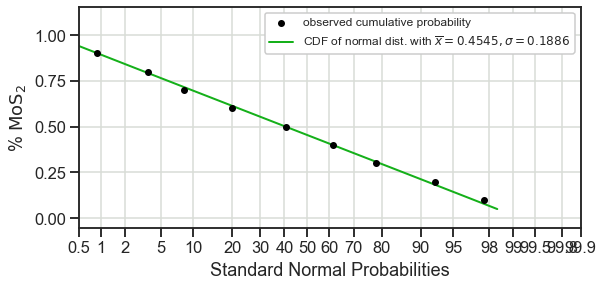

In [7]:
lower_hist_bin_bnd = np.linspace(0.9,0.0,10)
x_data = 100*np.array([0.009,0.037,0.084,0.200,0.405,0.614,0.781,0.926,0.977,1.00])
y_data_mod = np.linspace(0.05,1.1,100)
prob_x_data = 100*(1-norm.cdf(y_data_mod, loc=0.4545, scale=0.1886))

fig_one, ax_one = plt.subplots(figsize=(9, 4), dpi=72)
ax_one.scatter(x_data, lower_hist_bin_bnd, 30, marker='o', zorder=3,
               edgecolor='xkcd:black', facecolor='xkcd:black', label='observed cumulative probability')
ax_one.plot(prob_x_data, y_data_mod, color='xkcd:green', linewidth=2, zorder=2, label=r'CDF of normal dist. with $\overline{x}=0.4545, \sigma=0.1886$')
ax_one.set_xlim(0.5, 99.9)
ax_one.set_xscale('prob')
ax_one.grid(visible=True, which='both', color='xkcd:light grey')
ax_one.legend(fontsize=12, facecolor='xkcd:white', framealpha=1.0)
ax_one.set_xlabel('Standard Normal Probabilities', labelpad=6)
ax_one.set_ylabel(r'% $\mathrm{MoS_2}$', labelpad=6)

# delete the variables
del lower_hist_bin_bnd, x_data, y_data_mod, prob_x_data

The plot above applies for data that are dominated with a population with particular mean and standard deviation. However, there are cases when a dataset is contributed by two or more populations with various percentages. When this happens, the CDF of a normally distributed population $X_i \sim \mathcal{N}\left(\overline{x}_i, \sigma_i^2\right)$ will be scaled by its percentage and thus shown as a curved line in the probability graph (see code below, the <span style="color:#0343df;">blue</span> and <span style="color:#f97306;">orange</span> lines). The CDF of the whole dataset (**black line**) will be described by the superposition of both lines.

Suppose a researcher ([Masanovic et al., 2020](https://doi.org/10.4067%2FS0717-95022020000200382)) is surveying the body height statistics of 445 individuals, 266 boys and 179 girls. In proportional terms, the boys and girls comprise of 59.78% and 40.22% of the sampled population, respectively. From this survey, they got that the boys' and girls' body height are normally distributed with the following properties.
* Boys' body height mean is $176.57 \;\mathrm{cm}$ with a standard deviation of $\pm7.36 \;\mathrm{cm}$, symbolised by $X_1 \sim \mathcal{N}\left(176.57,54.17\right)$.
* Girls' body height mean is $166.84 \;\mathrm{cm}$ with a standard deviation of $\pm9.28 \;\mathrm{cm}$, symbolised by $X_2 \sim \mathcal{N}\left(166.84,86.12\right)$.

In the figure below, the theoretical CDF of the <span style="color:#0343df;">boys' body height</span> dataset is coloured <span style="color:#0343df;">blue</span>, while the theoretical CDF of <span style="color:#f97306;">girls' body height</span> dataset is drawn in <span style="color:#f97306;">orange line</span>.

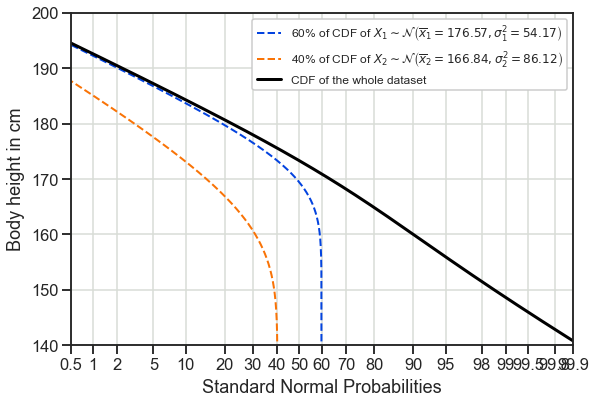

In [8]:
#y_data_mod_log = np.linspace(-2,2.0,1000)
#y_data_mod = 10**y_data_mod_log
y_data_mod = np.linspace(100,200,1000)
perc1 = 59.78
loc1 = 176.57
sigma1 = 7.36
perc2 = 40.22
loc2 = 166.84
sigma2 = 9.28
prob_x1_data = perc1*(1-norm.cdf(y_data_mod, loc=loc1, scale=sigma1))
prob_x2_data = perc2*(1-norm.cdf(y_data_mod, loc=loc2, scale=sigma2))
prob_x3_data = prob_x1_data + prob_x2_data

# Dynamically create the label for the first plot
label_x1 = fr'{perc1:.0f}% of CDF of $X_{{1}}\sim\mathcal{{N}}\left(\overline{{x}}_1={loc1:.2f}, \sigma_1^2={sigma1**2:.2f}\right)$'
label_x2 = fr'{perc2:.0f}% of CDF of $X_{{2}}\sim\mathcal{{N}}\left(\overline{{x}}_2={loc2:.2f}, \sigma_2^2={sigma2**2:.2f}\right)$'

fig_one, ax_one = plt.subplots(figsize=(9, 6), dpi=72)
ax_one.plot(prob_x1_data, y_data_mod, color='xkcd:blue', linewidth=2, zorder=2, linestyle='--',
            label=label_x1)
ax_one.plot(prob_x2_data, y_data_mod, color='xkcd:orange', linewidth=2, zorder=2, linestyle='--',
            label=label_x2)
ax_one.plot(prob_x3_data, y_data_mod, color='xkcd:black', linewidth=3, zorder=2, label=r'CDF of the whole dataset')
ax_one.set_xlim(0.5, 99.9)
ax_one.set_ylim(140, 200)
ax_one.set_xscale('prob')
ax_one.grid(visible=True, which='both', color='xkcd:light grey')
ax_one.legend(fontsize=12, facecolor='xkcd:white', framealpha=1.0)
ax_one.set_xlabel('Standard Normal Probabilities', labelpad=6)
ax_one.set_ylabel(r'Body height in cm', labelpad=6)

# delete the variables
del y_data_mod, prob_x1_data, prob_x2_data, prob_x3_data

In another example from [Sinclair (1976, PDF page 50)](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf), we consider a big copper ore assay dataset composed of two populations: high grade and low grade. Because the copper ore percentage spans several orders of magnitude, they are presented as their base-10 logarithms. The statistical parameters of the populations are as follows.

_**Note:**_ $s_L = 10$ to the power of the standard deviation (or $\sigma$) of $\mathrm{log_{10}{\left(dataset\;values\right)}}$.

| Populations | Proportions | Number of data | Average % | Average % $+ s_L$ | Average % $- s_L$ | Average of $\log_{10}\left(\%\right)$ | Average of $\log_{10}\left(\%\right)+$ its $|\sigma|$ | Average of $\log_{10}\left(\%\right)-$ its $|\sigma|$ | $|\sigma|$ |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| High Grade Ore | 62% | 56 | 9.5% | 16.1% | 5.6% | 0.98 | 1.21 | 0.75 | 0.23 |
| Low Grade Ore | 38% | 35 | 0.51% | 1.63% | 0.16% | -0.29 | 0.21 | -0.80 | 0.50 |

We make a similar plot as above, with the y-axis or ordinate showing the $\log_{10}\left(\mathrm{\%\;ore}\right)$, <span style="color:#f97306;">high grade ore CDF</span> in <span style="color:#f97306;">orange line</span> and <span style="color:#0343df;">low grade ore CDF</span> in <span style="color:#0343df;">blue</span>. Combined CDF is shown in **black line**.

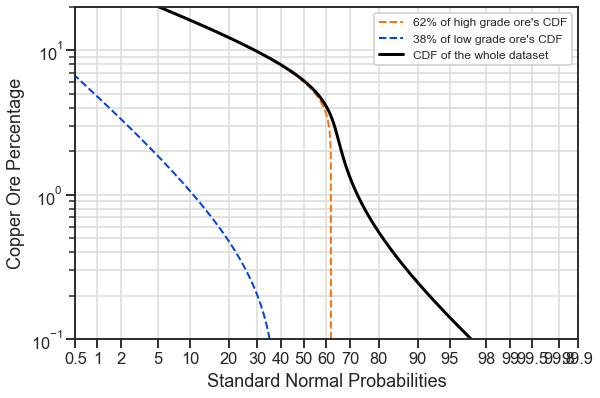

In [9]:
y_data_mod_log = np.linspace(-1,1.5,1000)
y_data_mod = 10**np.linspace(-1,1.5,1000)
perc1 = 62
loc1 = 0.98
sigma1 = 0.23
perc2 = 38
loc2 = -0.29
sigma2 = 0.50
prob_x1_data = perc1*(1-norm.cdf(y_data_mod_log, loc=loc1, scale=sigma1))
prob_x2_data = perc2*(1-norm.cdf(y_data_mod_log, loc=loc2, scale=sigma2))
prob_x3_data = prob_x1_data + prob_x2_data

# Dynamically create the label for the first plot
label_x1 = fr'''{perc1:.0f}% of high grade ore's CDF'''
label_x2 = fr'''{perc2:.0f}% of low grade ore's CDF'''

fig_one, ax_one = plt.subplots(figsize=(9, 6), dpi=72)
ax_one.plot(prob_x1_data, y_data_mod, color='xkcd:orange', linewidth=2, zorder=2, linestyle='--',
            label=label_x1)
ax_one.plot(prob_x2_data, y_data_mod, color='xkcd:blue', linewidth=2, zorder=2, linestyle='--',
            label=label_x2)
ax_one.plot(prob_x3_data, y_data_mod, color='xkcd:black', linewidth=3, zorder=2, label=r'CDF of the whole dataset')
ax_one.set_xlim(0.5, 99.9)
ax_one.set_ylim(0.1, 20)
ax_one.set_yscale('log')
ax_one.set_xscale('prob')
ax_one.grid(visible=True, which='both', color='xkcd:light grey')
ax_one.legend(fontsize=12, facecolor='xkcd:white', framealpha=1.0)
ax_one.set_xlabel('Standard Normal Probabilities', labelpad=6)
ax_one.set_ylabel(r'Copper Ore Percentage', labelpad=6)

# delete the variables
del y_data_mod_log, y_data_mod, prob_x1_data, prob_x2_data, prob_x3_data

## CDF of A Dataset with a Censored Distribution

A **censored distribution** is a dataset for which measurements are known for items on one side of a specific value but only number of items is known on the other side. Common examples of censored distributions are sets of analytical data for which some values are reported as (a) greater than a particular value, or (b) zero or not detected or less than detection limit [(Sinclair, 1976, PDF page 24)](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf). Hence, in censored distributions, the cumulative probability scatter will lie along a straight line beyond or before a particular value (See Figure A below). When a censored distribution can be fitted by the CDF of a percentage of a population (<span style="color:red;">red curves</span> in figure below), we do not know the composition of the censored populations (<span style="color:green;">green</span> and <span style="color:blue;">blue</span> curves in figure below, also see [Sinclair, 1976, PDF page 80](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf)) because they:
* have means far below (or above) the mean of the known population, and
* have standard deviations equal or narrower than the standard deviation of the known population.

>**Censored population (may) tell no tales.**

If the mean of a censored population is close to that of the known population, or if the censored population has a relatively large standard deviation, a portion of its CDF may influence the observed CDF at one side (upper or lower, not both). This allows us to estimate the censored population's mean and standard deviation.

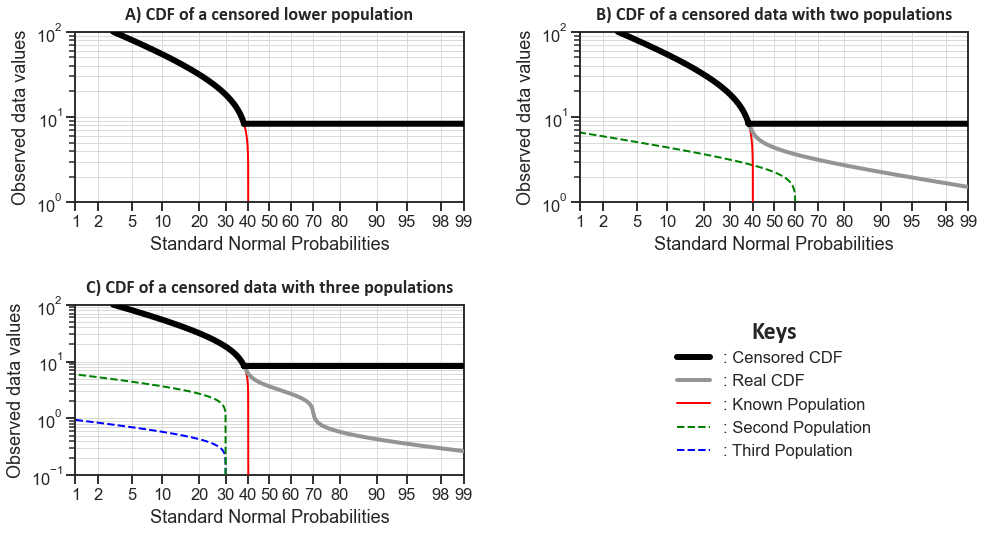

In [10]:
# Define constants
x0 = -1
x1 = 2
array_1_log = np.linspace(x0, x1, int(1e3))
array_1 = 10**array_1_log

# FigA data
perc1_figA = 40
prob1_figA = perc1_figA * (1 - norm.cdf(array_1_log, loc=1.5, scale=0.35))

array_1_log_figA = array_1_log.copy()
index_equal38 = np.where(np.floor(prob1_figA) == 38)[0][-1]
array_1_log_figA[prob1_figA >= 38] = array_1_log[index_equal38]
prob_censor_figA = np.linspace(100,38,63)
prob1_figA_to100 = np.append(prob_censor_figA,prob1_figA)
array_1_log_figA_to100 = np.append(array_1_log[index_equal38]*np.ones(prob_censor_figA.shape),array_1_log_figA)

# FigB data
perc2_figB = 60
prob2_figB = perc2_figB * (1 - norm.cdf(array_1_log, loc=0.5, scale=0.15))
total_prob_figB = prob1_figA + prob2_figB

# FigC data
perc2_figC = 30
prob2_figC = perc2_figC * (1 - norm.cdf(array_1_log, loc=0.5, scale=0.15))

perc3_figC = 30
prob3_figC = perc3_figC * (1 - norm.cdf(array_1_log, loc=-0.3, scale=0.15))

total_prob_figC = prob1_figA + prob2_figC + prob3_figC

# Plotting
fig, ax = plt.subplots(2, 2, dpi=72, figsize=(16, 8), gridspec_kw={'hspace':0.6, 'wspace':0.3})

# Axes 1: FigA
ax[0, 0].plot(prob1_figA_to100, 10**array_1_log_figA_to100, color='black', linewidth=6, zorder=3, label='Censored CDF')
ax[0, 0].plot(prob1_figA, 10**array_1_log, color='red', linewidth=2, zorder=2, label='Known Population')
ax[0, 0].set_xscale('prob')
ax[0, 0].set_xlim(1,99)
ax[0, 0].set_xlabel('Standard Normal Probabilities', labelpad=6)
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(1,100)
ax[0, 0].set_ylabel('Observed data values', labelpad=6)
ax[0, 0].grid(visible=True, which='both', color='xkcd:light grey', linewidth=1)
ax[0, 0].set_title('A) CDF of a censored lower population', fontfamily='Calibri', fontweight='bold', pad=12)
#ax[0, 0].legend()

# Axes 2: FigB
ax[0, 1].plot(prob1_figA_to100, 10**array_1_log_figA_to100, color='black', linewidth=6, zorder=5, label='Censored CDF')
ax[0, 1].plot(total_prob_figB, 10**array_1_log, color='xkcd:gray', linewidth=4, zorder=4, label='Real CDF')
ax[0, 1].plot(prob1_figA, 10**array_1_log, color='red', linewidth=2, zorder=3, label='Known Population')
ax[0, 1].plot(prob2_figB, 10**array_1_log, color='green', linewidth=2, zorder=2, linestyle='--', label='Second Population')
ax[0, 1].set_xscale('prob')
ax[0, 1].set_xlim(1,99)
ax[0, 1].set_xlabel('Standard Normal Probabilities', labelpad=6)
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylim(1,100)
ax[0, 1].set_ylabel('Observed data values', labelpad=6)
ax[0, 1].grid(visible=True, which='both', color='xkcd:light grey', linewidth=1)
ax[0, 1].set_title('B) CDF of a censored data with two populations', fontfamily='Calibri', fontweight='bold', pad=12)
#ax[0, 1].legend()

# Axes 3: FigC
ax[1, 0].plot(prob1_figA_to100, 10**array_1_log_figA_to100, color='black', linewidth=6, zorder=6, label='Censored CDF')
ax[1, 0].plot(total_prob_figC, 10**array_1_log, color='xkcd:gray', linewidth=4, zorder=5, label='Real CDF')
ax[1, 0].plot(prob1_figA, 10**array_1_log, color='red', linewidth=2, zorder=4, label='Known Population')
ax[1, 0].plot(prob2_figC, 10**array_1_log, color='green', linewidth=2, zorder=3, linestyle='--', label='Second Population')
ax[1, 0].plot(prob3_figC, 10**array_1_log, color='blue', linewidth=2, zorder=2, linestyle='--', label='Third Population')
ax[1, 0].set_xscale('prob')
ax[1, 0].set_xlim(1,99)
ax[1, 0].set_xlabel('Standard Normal Probabilities', labelpad=6)
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylim(0.1,100)
ax[1, 0].set_ylabel('Observed data values', labelpad=6)
ax[1, 0].grid(visible=True, which='both', color='xkcd:light grey', linewidth=1)
ax[1, 0].set_title('C) CDF of a censored data with three populations', fontfamily='Calibri', fontweight='bold', pad=12)
#ax[1, 0].legend()

# Axes 4: Legend Only
ax[1, 1].axis('off')
ax[1, 1].legend([
    plt.Line2D([0], [0], color='black', linewidth=6),
    plt.Line2D([0], [0], color='xkcd:gray', linewidth=4),
    plt.Line2D([0], [0], color='red', linewidth=2),
    plt.Line2D([0], [0], color='green', linewidth=2, linestyle='--'),
    plt.Line2D([0], [0], color='blue', linewidth=2, linestyle='--')],
                [': Censored CDF', ': Real CDF', ': Known Population', ': Second Population', ': Third Population'],
                title='Keys', title_fontproperties = {'weight':'bold', 'family':'Calibri', 'size':24},
                frameon=False, loc='center')

# delete the variables
del prob1_figA, prob2_figB, total_prob_figB, prob2_figC, prob3_figC, total_prob_figC

## The CDF of Rangitoto-Motutapu $\mathrm{CO_2}$ Gas Flux

Now, let’s turn to our Rangitoto-Motutapu $\mathrm{CO_2}$ gas flux data. A significant portion of this dataset (76.89%) consists of values below the detection limit ($<1.32\;\mathrm{grams/m^2/day}$), classifying it as a censored dataset ([Sinclair, 1976](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf)). However, with 107 values above the detection limit, we have sufficient data to plot and analyse on the probability graph.

The uncensored portion of gas flux's cumulative probability is well approximated ($R^2 = 0.99$) by a CDF (<span style="color:red;">red line</span>) contributed by 13% of <span style="color:green;">Population A (green line)</span> and 10% of <span style="color:blue;">Population B (blue line)</span>. The parameters of these populations are:
* Population A with mean $\mathrm{CO_{2}}$ gas flux $= 0.6\;\mathrm{grams/m^2/day}$  and standard deviation $= 0.25\;\mathrm{grams/m^2/day},$
* Population B with mean $\mathrm{CO_{2}}$ gas flux $= 1.0\;\mathrm{grams/m^2/day}$ and standard deviation $= 0.25\;\mathrm{grams/m^2/day},$

The two populations have similar standard deviations, though Population A has a lower mean than Population B. This suggests that the observed Rangitoto-Motutapu $\mathrm{CO_2}$ gas emissions may originate from two distinct sources. One identified source is biological activity, whilst the other is a speculated, unidentified geological source. Elevated $\mathrm{CO_2}$ gas flux observed in several grassy areas on Motutapu Island can be positively attributed to biological sources. However, what about Rangitoto? Can its elevated $\mathrm{CO_2}$ gas flux be singularly linked to an unknown geological source, or is there contamination from biological sources associated with the bushes and forests lining the barren gravel road where the measurements were taken? The CDF and Population plots below cannot answer this question as they are derived from a mixture of Rangitoto and Motutapu data. To determine which populations comprise the Rangitoto $\mathrm{CO_2}$ gas flux data, we need to create its own CDF and population plots. If we wish to compare, we can produce the same for Motutapu as well.

RMS Fit: 0.6376069709887395
R-squared: 0.9908568711550243


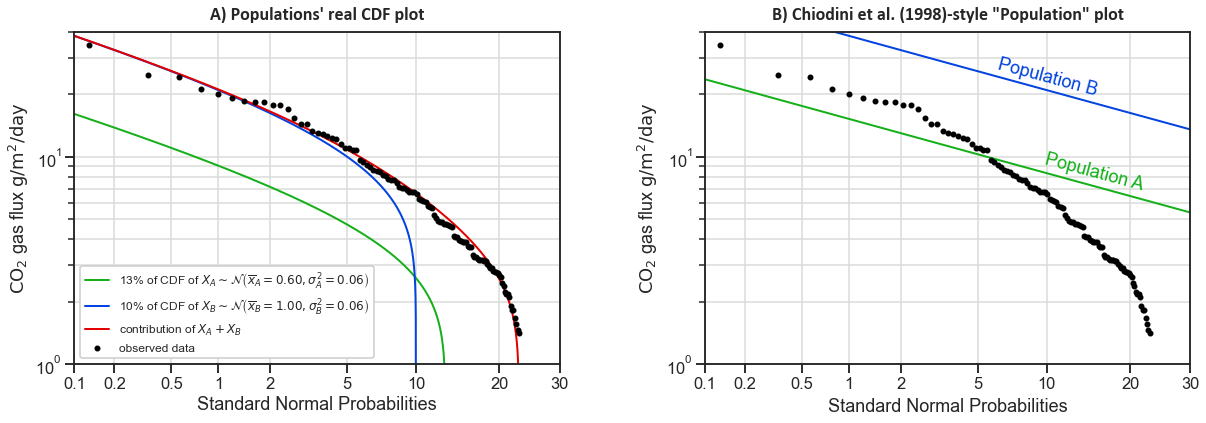

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=72, gridspec_kw={'wspace':0.3})

common_opts = dict(
    probax='x',
    datascale='log',
    datalabel=r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$',
    scatter_kws=dict(marker='.', linestyle='none')
)

#### CDF style plot ####
probplot1, res = probscale.probplot(x_nonzero, ax=ax[0], return_best_fit_results=True, plottype='prob',
                                    problabel='Standard Normal Probabilities',  **common_opts)
#delete the probplot from the axes because we do not need it
for artist in ax[0].lines + ax[0].collections:
    artist.remove()

gasflux_log_mock = np.linspace(-3, 2, 10000)
gasflux_mock = 10**gasflux_log_mock
perc1 = 13.00
loc1 = 0.6
sigma1 = 0.25
perc2 = 10.00
loc2 = 1.0
sigma2 = 0.25
prob_X1 = perc1*(1-norm.cdf(gasflux_log_mock, loc=loc1, scale=sigma1))
prob_X2 = perc2*(1-norm.cdf(gasflux_log_mock, loc=loc2, scale=sigma2))

# Dynamically create the label for the first plot
label_x1 = fr'{perc1:.0f}% of CDF of $X_{{A}}\sim\mathcal{{N}}\left(\overline{{x}}_A={loc1:.2f}, \sigma_A^2={sigma1**2:.2f}\right)$'
label_x2 = fr'{perc2:.0f}% of CDF of $X_{{B}}\sim\mathcal{{N}}\left(\overline{{x}}_B={loc2:.2f}, \sigma_B^2={sigma2**2:.2f}\right)$'

ax[0].plot(prob_X1, gasflux_mock, color='xkcd:green', linewidth=2, zorder=2, label=label_x1)
ax[0].plot(prob_X2, gasflux_mock, color='xkcd:blue', linewidth=2, zorder=2, label=label_x2)
ax[0].plot(prob_X1+prob_X2, gasflux_mock, color='xkcd:red', linewidth=2, zorder=2, label=r'contribution of $X_{A} + X_{B}$')
prob_X = res['x']
gasflux_Y = res['y']
idx_nonzero = np.argmax(gasflux_Y != 1.3)
prob_X1_toTest = perc1*(1-norm.cdf(np.log10(gasflux_Y[idx_nonzero:]), loc=loc1, scale=sigma1))
prob_X2_toTest = perc2*(1-norm.cdf(np.log10(gasflux_Y[idx_nonzero:]), loc=loc2, scale=sigma2))
prob_XTot_toTest = prob_X1_toTest+prob_X2_toTest

# Compute values
rms = calculate_rms(100-prob_X[idx_nonzero:], prob_XTot_toTest)
r_squared = calculate_r_squared(100-prob_X[idx_nonzero:], prob_XTot_toTest)

# Print results
print(f"RMS Fit: {rms}")
print(f"R-squared: {r_squared}")

idx_nonzero = np.argmax(gasflux_Y != 1.3)
ax[0].scatter(100-prob_X[idx_nonzero:], gasflux_Y[idx_nonzero:], 80, marker='.', zorder=3,
           edgecolor='xkcd:black', facecolor='xkcd:black', label='observed data')

ax[0].grid(visible=True, which='both', color='xkcd:light grey')
ax[0].set_xlim(left=0.1, right=30)
ax[0].set_ylim(bottom=1, top=40)
ax[0].set_title('''A) Populations' real CDF plot''', fontfamily='Calibri', fontweight='bold', pad=12)
ax[0].legend(fontsize=12, facecolor='xkcd:white', framealpha=1.0)

#### Chiodini "population" style plot ####
ax[1].plot((100/perc1)*prob_X1, gasflux_mock, color='xkcd:green', linewidth=2, zorder=2, label=label_x1)
ax[1].plot((100/perc2)*prob_X2, gasflux_mock, color='xkcd:blue', linewidth=2, zorder=2, label=label_x2)
ax[1].scatter(100-prob_X[idx_nonzero:], gasflux_Y[idx_nonzero:], 80, marker='.', zorder=3,
           edgecolor='xkcd:black', facecolor='xkcd:black', label='observed data')
# Plot text with specified properties
ax[1].text(15, 8, 'Population A', color='xkcd:green',
           va='baseline', ha='center',
           rotation=-15, rotation_mode='anchor')
ax[1].text(10, 23, 'Population B', color='xkcd:blue',
           va='baseline', ha='center',
           rotation=-15, rotation_mode='anchor')
# Misc.
ax[1].set_xscale('prob')
ax[1].set_yscale('log')
ax[1].grid(visible=True, which='both', color='xkcd:light grey')
ax[1].set_xlim(left=0.1, right=30)
ax[1].set_ylim(bottom=1, top=40)
ax[1].set_xlabel('Standard Normal Probabilities', labelpad=6)
ax[1].set_ylabel(r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$', labelpad=6)
ax[1].set_title('B) Chiodini et al. (1998)-style "Population" plot', fontfamily='Calibri', fontweight='bold', pad=12)

# delete the variables
del gasflux_log_mock, gasflux_mock, prob_X1, prob_X2, prob_X1_toTest, prob_X2_toTest, prob_XTot_toTest, probplot1, res

## The CDF of Rangitoto $\mathrm{CO_{2}}$ Gas Flux

Of the 463 Rangitoto-Motutapu $\mathrm{CO_{2}}$ gas flux values, 340 were collected on Rangitoto. Of these 340 Rangitoto $\mathrm{CO_{2}}$ gas flux values, only 77 (23%) are above the detection limit. Although this is fewer than the arbitrary minimum of 100 data points required for creating a cumulative probability plot ([Sinclair, 1976](https://www.appliedgeochemists.org/sites/default/files/documents/Members%20area/Probability%20Plots%20Special%20Vol.%204%20by%20Sinclair.pdf)), the Rangitoto $\mathrm{CO_{2}}$ gas flux cumulative probability scatter traces a smooth curve characteristic of a percentage of a population's CDF (<span style="color:purple;">purple line</span>). Through trial and error, we successfully fitted the scatter with 24% of a single-population CDF, with population mean of $0.70\;\mathrm{grams/m^2/day}$ and population standard deviation of $0.31\;\mathrm{grams/m^2/day}.$ This fit yields an $R^2=0.99,$ making additional populations unnecessary.

The successful fitting of the Rangitoto $\mathrm{CO_{2}}$ gas flux cumulative probability distribution by a single CDF suggests that wherever elevated $\mathrm{CO_{2}}$ gas flux is observed on the island, the source remains consistent. For Rangitoto, we suggest that the source of the diffuse $\mathrm{CO_{2}}$ gas emissions is geological, since the magnitude of these emissions (which are associated with a single population) is uncorrelated with the type and density of vegetation growing around them. The slight deviation of the $24\;\mathrm{grams/m^2/day}$ data point below the theoretical CDF may indicate insufficient sampling of areas with $\mathrm{CO_{2}}$ gas flux greater than $20\;\mathrm{grams/m^2/day}$ on Rangitoto.

In [12]:
CO2_data_rangiOnly = data_SP_rangiOnly["CO2_gm-2d-1"].to_numpy()

# Replace zeros with a small value (e.g., half the detection limit)
detection_limit = 1.3
x_nonzero_rangiOnly = np.where(CO2_data_rangiOnly == 0, detection_limit, CO2_data_rangiOnly)
x_nonzero_v2_rangiOnly = CO2_data_rangiOnly[CO2_data_rangiOnly>0]
print(fr"Length of all Rangitoto-Motutapu data is {len(data_SP_CO2):d}")
print(fr"Length of all Rangitoto data is: {len(CO2_data_rangiOnly):d}")
print(fr"Length of nonzero Rangitoto data is: {len(x_nonzero_v2_rangiOnly):d}")
print(fr"Percentage of nonzero data is: {np.round(100*(len(x_nonzero_v2_rangiOnly)/len(CO2_data_rangiOnly))):.0f}")

Length of all Rangitoto-Motutapu data is 463
Length of all Rangitoto data is: 340
Length of nonzero Rangitoto data is: 77
Percentage of nonzero data is: 23


RMS Fit: 0.32964518061403975
R-squared: 0.9974541364030425


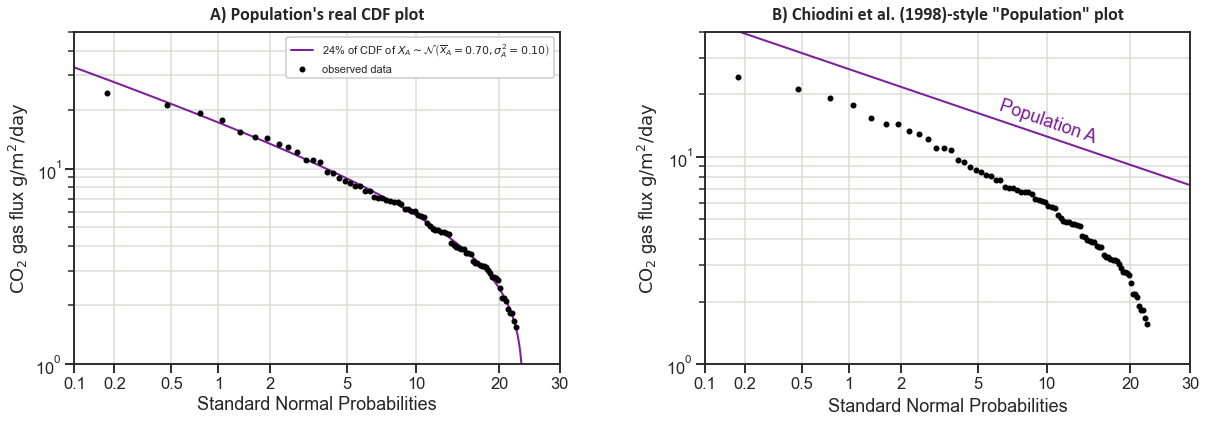

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=72, gridspec_kw={'wspace':0.3})

#### CDF style plot ####
common_opts = dict(
    probax='x',
    datascale='log',
    datalabel=r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$',
    scatter_kws=dict(marker='.', linestyle='none')
)

probplot2, res_rangiOnly = probscale.probplot(x_nonzero_rangiOnly, ax=ax[0], return_best_fit_results=True, plottype='prob',
                                    problabel='Standard Normal Probabilities',  **common_opts)
for artist in ax[0].lines + ax[0].collections:
    artist.remove()

gasflux_log_mock = np.linspace(-3, 2, 10000)
gasflux_mock = 10**gasflux_log_mock
perc1 = 23.70
loc1 = 0.7
sigma1 = 0.31
prob_X1 = perc1*(1-norm.cdf(gasflux_log_mock, loc=loc1, scale=sigma1))

# Dynamically create the label for the first plot
label_x1 = fr'{perc1:.0f}% of CDF of $X_{{A}}\sim\mathcal{{N}}\left(\overline{{x}}_A={loc1:.2f}, \sigma_A^2={sigma1**2:.2f}\right)$'

ax[0].plot(prob_X1, gasflux_mock, color='xkcd:purple', linewidth=2, zorder=2, label=label_x1)
prob_X_rangiOnly = res_rangiOnly['x']
gasflux_Y_rangiOnly = res_rangiOnly['y']
idx_nonzero = np.argmax(gasflux_Y_rangiOnly != 1.3)
prob_X1_toTest = perc1*(1-norm.cdf(np.log10(gasflux_Y_rangiOnly[idx_nonzero:]), loc=loc1, scale=sigma1))

# Compute values
rms_rangiOnly = calculate_rms(100-prob_X_rangiOnly[idx_nonzero:], prob_X1_toTest)
r_squared_rangiOnly = calculate_r_squared(100-prob_X_rangiOnly[idx_nonzero:], prob_X1_toTest)

# Print results
print(f"RMS Fit: {rms_rangiOnly}")
print(f"R-squared: {r_squared_rangiOnly}")

ax[0].scatter(100-prob_X_rangiOnly[idx_nonzero:], gasflux_Y_rangiOnly[idx_nonzero:], 80, marker='.', zorder=3,
           edgecolor='xkcd:black', facecolor='xkcd:black', label='observed data')

ax[0].grid(visible=True, which='both', color='xkcd:light grey')
ax[0].set_xlim(left=0.1, right=30)
ax[0].set_ylim(bottom=1, top=50)
ax[0].set_title('''A) Population's real CDF plot''', fontfamily='Calibri', fontweight='bold', pad=12)
ax[0].legend(fontsize=11, facecolor='xkcd:white', framealpha=1.0)

#### Chiodini "population" style plot ####
ax[1].plot((100/perc1)*prob_X1, gasflux_mock, color='xkcd:purple', linewidth=2, zorder=2, label=label_x1)
ax[1].scatter(100-prob_X_rangiOnly[idx_nonzero:], gasflux_Y_rangiOnly[idx_nonzero:], 80, marker='.', zorder=3,
           edgecolor='xkcd:black', facecolor='xkcd:black', label='observed data')
# Plot text with specified properties
ax[1].text(10, 14, 'Population A', color='xkcd:purple',
           va='baseline', ha='center',
           rotation=-19, rotation_mode='anchor')

# Misc.
ax[1].set_xscale('prob')
ax[1].set_yscale('log')
ax[1].grid(visible=True, which='both', color='xkcd:light grey')
ax[1].set_xlim(left=0.1, right=30)
ax[1].set_ylim(bottom=1, top=40)
ax[1].set_xlabel('Standard Normal Probabilities', labelpad=6)
ax[1].set_ylabel(r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$', labelpad=6)
ax[1].set_title('B) Chiodini et al. (1998)-style "Population" plot', fontfamily='Calibri', fontweight='bold', pad=12)

# delete the variables
del gasflux_log_mock, gasflux_mock, prob_X1, prob_X1_toTest, probplot2, res_rangiOnly

(1, 40)

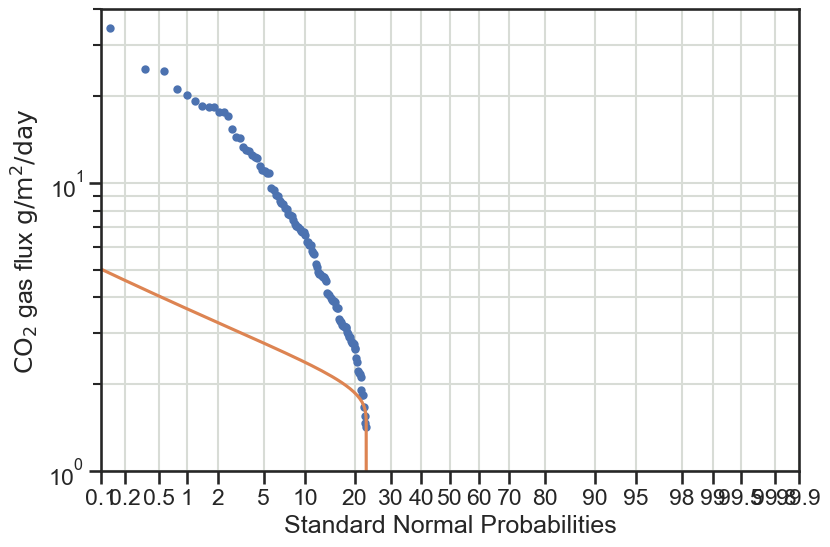

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))

common_opts = dict(
    probax='x',
    datascale='log',
    datalabel=r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$',
    scatter_kws=dict(marker='.', linestyle='none')
)

probplot1, res = probscale.probplot(x_nonzero, ax=ax, return_best_fit_results=True, plottype='prob',
                                    problabel='Standard Normal Probabilities',  **common_opts)
for artist in ax.lines + ax.collections:
    artist.remove()

gasflux_mock = np.linspace(1, 50, 1000)
prob_X2 = 100*lognorm.cdf(gasflux_mock,0.5, loc=1.3, scale=1)
#ax.plot(prob_X2, gasflux_mock)
prob_X = res['x']
gasflux_Y = res['y']
idx_nonzero = np.argmax(gasflux_Y != 1.3)
ax.scatter(100-prob_X[idx_nonzero:], gasflux_Y[idx_nonzero:], marker='.')
ax.plot(0.23*(100-prob_X2), gasflux_mock)

ax.grid(visible=True, which='both', color='xkcd:light grey')
ax.set_xlim(left=0.1, right=99.90)
ax.set_ylim(bottom=1, top=40)

(2.0, 98.0)

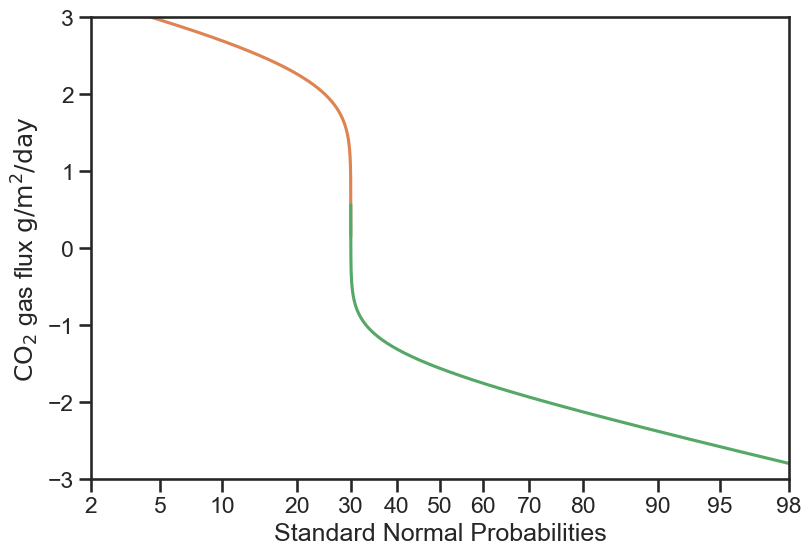

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))

common_opts = dict(
    probax='x',
    datascale='linear',
    datalabel=r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$',
    scatter_kws=dict(marker='.', linestyle='none')
)

probplot1, res = probscale.probplot(x_nonzero, ax=ax, return_best_fit_results=True, plottype='prob',
                                    problabel='Standard Normal Probabilities',  **common_opts)
for artist in ax.lines + ax.collections:
    artist.remove()

gasflux_mock = np.log10(10**np.linspace(-3, 3, 1000))
prob_A = 30*(1-norm.cdf(gasflux_mock, loc=np.log10(300), scale=0.5))
idx_probA_no30 = np.argmax(np.round(prob_A,4) != 30.00)
prob_B = 100-70*(1-norm.cdf(-gasflux_mock, loc=np.log10(70), scale=0.5))
idx_probB_no30 = np.argmin(np.round(prob_B,4) != 30.00)
#prob_C = prob_A + prob_B

ax.plot(prob_A[idx_probA_no30:], gasflux_mock[idx_probA_no30:])
ax.plot(prob_B[:idx_probB_no30], gasflux_mock[:idx_probB_no30])
#ax.plot(prob_C, gasflux_mock)

ax.set_ylim(bottom=np.log10(1e-3), top=np.log10(1e+3))
ax.set_xlim(2, 98)

## The CDF of Motutapu $\mathrm{CO_2}$ Gas Flux

Although we already know that areas of elevated $\mathrm{CO_{2}}$ gas flux on Motutapu are detected over grassy areas and hence associated with biological activities in that ecosystem, we conducted population analysis on Motutapu's $\mathrm{CO_{2}}$ gas flux data for comparison. Of the 123 $\mathrm{CO_{2}}$ gas flux measurements collected on Motutapu, 30 (24%) are above the detection limit.

Visual inspection reveals two kinks in the Motutapu $\mathrm{CO_{2}}$ gas flux cumulative probability scatter, indicating that at least three distinct populations contributed to the observed Motutapu $\mathrm{CO_{2}}$ gas flux anomalies:
* 9% of <span style="color:purple;">Population A (purple line)</span>, with a mean of $0.5\;\mathrm{grams/m^2/day}$ and a standard deviation of $0.09\;\mathrm{grams/m^2/day}.$
* 10% of <span style="color:green;">Population B (green line)</span>, with a mean of $1.1\;\mathrm{grams/m^2/day}$ and a standard deviation of $0.15\;\mathrm{grams/m^2/day}.$
* 4% of <span style="color:blue;">Population C (blue line)</span>, with a mean of $1.2\;\mathrm{grams/m^2/day}$ and a standard deviation of $0.3\;\mathrm{grams/m^2/day}.$

Population A, whose parameters are similar to those of the population causing Rangitoto's anomalous $\mathrm{CO_{2}}$ gas flux, may be linked to a similar geological $\mathrm{CO_{2}}$ source as suggested for the volcano. Populations B and C, which have slightly different means but both approximately twice that of Population A, can be linked to biological sources due to their magnitude, despite the significant difference in their standard deviations (the standard deviation of Population B is half that of Population C).

Although the fit of the composite CDF from these three populations is very good $\left(R^2 = 0.98\right)$, the interpretation presented here should be treated with caution as it is drawn from a limited number of values and the CDF may consequently overfit. Additional $\mathrm{CO_{2}}$ gas flux measurements should be obtained on Motutapu to better characterise the populations contributing to anomalous $\mathrm{CO_{2}}$ gas flux emissions. Furthermore, future measurements should be conducted during the dry season using more sensitive equipment to minimise the number of below-detection values.

In [16]:
CO2_data_motuOnly = data_SP_motuOnly["CO2_gm-2d-1"].to_numpy()

# Replace zeros with a small value (e.g., half the detection limit)
detection_limit = 1.3
x_nonzero_motuOnly = np.where(CO2_data_motuOnly == 0, detection_limit, CO2_data_motuOnly)
x_nonzero_v2_motuOnly = CO2_data_motuOnly[CO2_data_motuOnly>0]

print(fr"Length of all Rangitoto-Motutapu data is {len(data_SP_CO2):d}")
print(fr"Length of all Motutapu data is: {len(CO2_data_motuOnly):d}")
print(fr"Length of nonzero Motutapu data is: {len(x_nonzero_v2_motuOnly):d}")
print(fr"Percentage of nonzero data is: {np.round(100*(len(x_nonzero_v2_motuOnly)/len(CO2_data_motuOnly))):.0f}")

Length of all Rangitoto-Motutapu data is 463
Length of all Motutapu data is: 123
Length of nonzero Motutapu data is: 30
Percentage of nonzero data is: 24


RMS Fit: 0.8627724535610986
R-squared: 0.9849188134830921


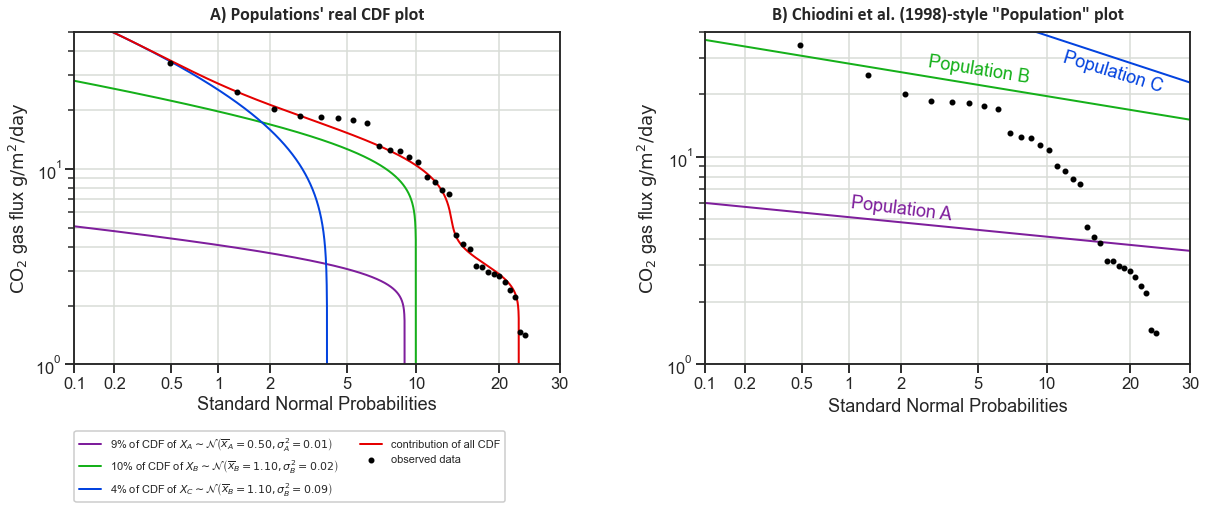

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=72, gridspec_kw={'wspace':0.3})

#### CDF style plot ####
common_opts = dict(
    probax='x',
    datascale='log',
    datalabel=r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$',
    scatter_kws=dict(marker='.', linestyle='none')
)

probplot3, res_motuOnly = probscale.probplot(x_nonzero_motuOnly, ax=ax[0], return_best_fit_results=True, plottype='prob',
                                    problabel='Standard Normal Probabilities',  **common_opts)
for artist in ax[0].lines + ax[0].collections:
    artist.remove()

gasflux_log_mock = np.linspace(-3, 2, 10000)
gasflux_mock = 10**gasflux_log_mock
perc1 = 9
loc1 = 0.5
sigma1 = 0.09
perc2 = 10
loc2 = 1.1
sigma2 = 0.15
perc3 = 4
loc3 = 1.2
sigma3 = 0.3

prob_X1 = perc1*(1-norm.cdf(gasflux_log_mock, loc=loc1, scale=sigma1))
prob_X2 = perc2*(1-norm.cdf(gasflux_log_mock, loc=loc2, scale=sigma2))
prob_X3 = perc3*(1-norm.cdf(gasflux_log_mock, loc=loc3, scale=sigma3))

# Dynamically create the label for the first plot
label_x1 = fr'{perc1:.0f}% of CDF of $X_{{A}}\sim\mathcal{{N}}\left(\overline{{x}}_A={loc1:.2f}, \sigma_A^2={sigma1**2:.2f}\right)$'
label_x2 = fr'{perc2:.0f}% of CDF of $X_{{B}}\sim\mathcal{{N}}\left(\overline{{x}}_B={loc2:.2f}, \sigma_B^2={sigma2**2:.2f}\right)$'
label_x3 = fr'{perc3:.0f}% of CDF of $X_{{C}}\sim\mathcal{{N}}\left(\overline{{x}}_B={loc2:.2f}, \sigma_B^2={sigma3**2:.2f}\right)$'

ax[0].plot(prob_X1, gasflux_mock, color='xkcd:purple', linewidth=2, zorder=2, label=label_x1)
ax[0].plot(prob_X2, gasflux_mock, color='xkcd:green', linewidth=2, zorder=2, label=label_x2)
ax[0].plot(prob_X3, gasflux_mock, color='xkcd:blue', linewidth=2, zorder=2, label=label_x3)
ax[0].plot(prob_X1+prob_X2+prob_X3, gasflux_mock, color='xkcd:red', linewidth=2, zorder=2, label=r'contribution of all CDF')
prob_X_motuOnly = res_motuOnly['x']
gasflux_Y_motuOnly = res_motuOnly['y']
idx_nonzero = np.argmax(gasflux_Y_motuOnly != 1.3)
prob_X1_toTest = perc1*(1-norm.cdf(np.log10(gasflux_Y_motuOnly[idx_nonzero:]), loc=loc1, scale=sigma1))
prob_X2_toTest = perc2*(1-norm.cdf(np.log10(gasflux_Y_motuOnly[idx_nonzero:]), loc=loc2, scale=sigma2))
prob_X3_toTest = perc3*(1-norm.cdf(np.log10(gasflux_Y_motuOnly[idx_nonzero:]), loc=loc3, scale=sigma3))
prob_XTot_toTest = prob_X1_toTest+prob_X2_toTest+prob_X3_toTest

# Compute values
rms_motuOnly = calculate_rms(100-prob_X_motuOnly[idx_nonzero:], prob_XTot_toTest)
r_squared_motuOnly = calculate_r_squared(100-prob_X_motuOnly[idx_nonzero:], prob_XTot_toTest)

# Print results
print(f"RMS Fit: {rms_motuOnly}")
print(f"R-squared: {r_squared_motuOnly}")

ax[0].scatter(100-prob_X_motuOnly[idx_nonzero:], gasflux_Y_motuOnly[idx_nonzero:], 80, marker='.', zorder=3,
           edgecolor='xkcd:black', facecolor='xkcd:black', label='observed data')

ax[0].grid(visible=True, which='both', color='xkcd:light grey')
ax[0].set_xlim(left=0.1, right=30)
ax[0].set_ylim(bottom=1, top=50)
ax[0].set_title('''A) Populations' real CDF plot''', fontfamily='Calibri', fontweight='bold', pad=12)
ax[0].legend(fontsize=11, facecolor='xkcd:white', framealpha=1.0, loc='upper left', bbox_to_anchor=(0, -0.2), ncols=2, borderaxespad=0)

#### Chiodini "population" style plot ####
ax[1].plot((100/perc1)*prob_X1, gasflux_mock, color='xkcd:purple', linewidth=2, zorder=2, label=label_x1)
ax[1].plot((100/perc2)*prob_X2, gasflux_mock, color='xkcd:green', linewidth=2, zorder=2, label=label_x2)
ax[1].plot((100/perc3)*prob_X3, gasflux_mock, color='xkcd:blue', linewidth=2, zorder=2, label=label_x3)

ax[1].scatter(100-prob_X_motuOnly[idx_nonzero:], gasflux_Y_motuOnly[idx_nonzero:], 80, marker='.', zorder=3,
           edgecolor='xkcd:black', facecolor='xkcd:black', label='observed data')
# Plot text with specified properties
ax[1].text(2, 5.3, 'Population A', color='xkcd:purple',
           va='baseline', ha='center',
           rotation=-7, rotation_mode='anchor')
ax[1].text(5, 25, 'Population B', color='xkcd:green',
           va='baseline', ha='center',
           rotation=-9, rotation_mode='anchor')
ax[1].text(18, 28, 'Population C', color='xkcd:blue',
           va='top', ha='center',
           rotation=-17, rotation_mode='anchor')

# Misc.
ax[1].set_xscale('prob')
ax[1].set_yscale('log')
ax[1].grid(visible=True, which='both', color='xkcd:light grey')
ax[1].set_xlim(left=0.1, right=30)
ax[1].set_ylim(bottom=1, top=40)
ax[1].set_xlabel('Standard Normal Probabilities', labelpad=6)
ax[1].set_ylabel(r'$\mathrm{CO_2}$ gas flux $\mathrm{g/m^2/day}$', labelpad=6)
ax[1].set_title('B) Chiodini et al. (1998)-style "Population" plot', fontfamily='Calibri', fontweight='bold', pad=12)

# delete the variables
del gasflux_log_mock, gasflux_mock, prob_X1, prob_X2, prob_X3, prob_X1_toTest, prob_X2_toTest, prob_X3_toTest, probplot3, res_motuOnly

## Gaussian Mixture Model of Motutapu $\mathrm{CO_2}$ Gas Flux Data

This section serves as a "proof-of-concept" for gas flux data categorisation when multiple populations are identified in the gas flux data and how these categories are distributed spatially in the field. As the data used for categorisation are limited, the results may reflect overfitting rather than reality, and the following analysis should be understood as a coding experiment rather than a definitive scientific investigation. To categorise the data into groups likely belonging to Population A, B, or C, we used the [Gaussian Mixture Model (GMM)](https://scikit-learn.org/stable/modules/mixture.html) with predefined initial population parameters from the previous section. We did not perform this analysis for Rangitoto $\mathrm{CO_2}$ gas flux data as these comprise only one population.

Using the [GMM](https://scikit-learn.org/stable/modules/mixture.html), we found that anomalous Motutapu $\mathrm{CO_2}$ gas flux data are likely to belong to either Population B or C, with none likely belonging to Population A. Twenty-eight anomalous $\mathrm{CO_2}$ gas flux values are grouped in Population B, whilst only two data points, located at sites separated by approximately 500 m, are grouped in Population C. The first Population C point is located at an acute-angle intersection between two tracks, where rainwater runoff converges to deposit organic materials and create a larger flow. The second Population C point is situated at the end of our Rangitoto-Motutapu $\mathrm{SP-CO_2}$ gas flux measurement transect, which we noted was very muddy and likely to contain high levels of organic materials and associated biological activity.

Although the GMM suggests that no Motutapu anomalous $\mathrm{CO_2}$ gas flux data likely belong to Population A, the population analysis above suggests that Population A's effect may be masked by Population B, causing data with Population A characteristics to be grouped within Population B. This experiment highlights the importance of using more sensitive gas flux meters and conducting measurements during the dry season, when surface biological activities are lower and their $\mathrm{CO_2}$ emissions are less likely to mask $\mathrm{CO_2}$ gas emitted from deeper geological sources. Moreover, groundwater, which typically impedes deeper-sourced geological $\mathrm{CO_2}$ gas from flowing upward, presents less of an obstacle during the dry season, resulting in potentially stronger geological $\mathrm{CO_2}$ gas flux during this period (for example, in GFUR1 and GFUR2 stations in the Azores archipelago, Portugal, [Viveiros et al., 2008](https://doi.org/10.1016/j.jvolgeores.2008.07.005)).

In [18]:
# Filter out below detection threshold
data_CO2_forGMM = data_SP_motuOnly[data_SP_motuOnly['CO2_gm-2d-1'] > 0.0].reset_index(drop=True)
MotuZeroCO2data = data_SP_motuOnly[data_SP_motuOnly['CO2_gm-2d-1'] == 0.0].reset_index(drop=True)

In [19]:
# Define initial parameters for populations (a) and (b)
means_init = np.array([[0.5], [1.2], [1.1]])  # Means for populations (a), (b), and (c)
weights_init = np.array([9/23, 4/23, 10/23])  # Proportions of populations (a), (b), and (c)
covariances_init = np.array([[[0.09**2]], [[0.3**2]], [[0.15**2]]])  # Variances for populations (a), (b), and (c)

# Fit GMM with predefined parameters
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=128)
gmm.means_init = means_init
gmm.weights_init = weights_init
gmm.precisions_init = np.linalg.inv(covariances_init)  # Convert variances to precisions
gmm.fit(data_CO2_forGMM[['CO2_gm-2d-1']])

# Add cluster assignments and probabilities to the dataset
data_CO2_forGMM['Cluster_CO2'] = gmm.predict(data_CO2_forGMM[['CO2_gm-2d-1']])
data_CO2_forGMM['Probability_CO2_a'], data_CO2_forGMM['Probability_CO2_b'], data_CO2_forGMM['Probability_CO2_c'] = gmm.predict_proba(data_CO2_forGMM[['CO2_gm-2d-1']]).T

# Convert to GeoDataFrame for spatial mapping
gdf_CO2 = gpd.GeoDataFrame(
    data_CO2_forGMM,
    geometry=gpd.points_from_xy(data_CO2_forGMM['X_NZTM'], data_CO2_forGMM['Y_NZTM']),
    crs="EPSG:2193"  # Use an appropriate CRS for your data
)

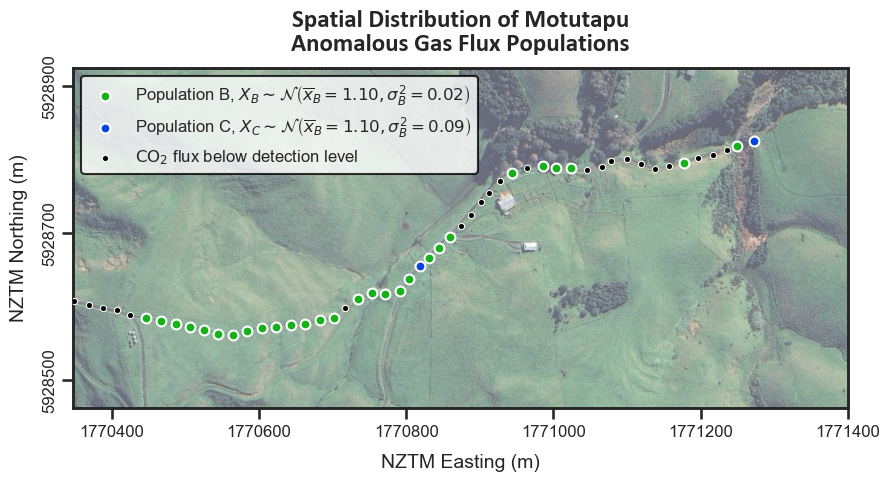

In [20]:
# Create figure and projection
google_maps = cimgt.GoogleTiles(style='satellite')

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw=dict(projection=ccrs.epsg(2193)))

# Set extent based on your data coordinates
# Replace these with your actual data bounds
map_extent = np.array([data_CO2_forGMM['X_NZTM'].min()-100, data_CO2_forGMM['X_NZTM'].max()+100, data_CO2_forGMM['Y_NZTM'].min()-100, data_CO2_forGMM['Y_NZTM'].max()+100])
ax.set_extent(map_extent, crs=ccrs.epsg(2193))

# Add Google Maps
ax.add_image(google_maps, 18, alpha=0.6, zorder=2)

# Create scatter plots for each category
colors = ['xkcd:purple', 'xkcd:green', 'xkcd:blue']  # colors for categories 0, 1, 2
labels = [fr'Population A, $X_{{A}}\sim\mathcal{{N}}\left(\overline{{x}}_A={loc1:.2f}, \sigma_A^2={sigma1**2:.2f}\right)$',
          fr'Population B, $X_{{B}}\sim\mathcal{{N}}\left(\overline{{x}}_B={loc2:.2f}, \sigma_B^2={sigma2**2:.2f}\right)$',
          fr'Population C, $X_{{C}}\sim\mathcal{{N}}\left(\overline{{x}}_B={loc2:.2f}, \sigma_B^2={sigma3**2:.2f}\right)$',
          r'$\mathrm{CO_2}$ flux below detection level']
scatter_plots = []

for i in range(3):
    mask = gdf_CO2['Cluster_CO2'] == i
    if len(gdf_CO2[mask]) == 0:
        del labels[i]
        continue
    scatter = ax.scatter(gdf_CO2[mask].geometry.x,
                         gdf_CO2[mask].geometry.y,
                         c=colors[i],
                         s=50,
                         edgecolors='xkcd:white',
                         label=labels[i],
                         transform=ccrs.epsg(2193),
                         zorder=6)
    scatter_plots.append(scatter)

scatter_zero = ax.scatter(MotuZeroCO2data['X_NZTM'],
                          MotuZeroCO2data['Y_NZTM'],
                          c='xkcd:black',
                          s=20,
                          edgecolors='xkcd:white',
                          linewidth=0.75,
                          label=r'$\mathrm{CO_2}$ flux below detection level',
                          transform=ccrs.epsg(2193),
                          zorder=4)
scatter_plots.append(scatter_zero)

# Create custom legend
legend = ax.legend(scatter_plots,
                   labels,
                   prop={'size':12},
                   frameon=True,
                   facecolor='white',
                   edgecolor='black',
                   loc='upper left')

# Add labels and title
ax.set_title("Spatial Distribution of Motutapu\nAnomalous Gas Flux Populations", fontfamily='Calibri', fontweight='bold', pad=12)
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# Replace the existing tick configuration with:
ax.set_xticks(np.arange(100*np.floor((data_CO2_forGMM['X_NZTM'].min())/100), 100*np.ceil((data_CO2_forGMM['X_NZTM'].max()+200)/100), 200))
ax.set_yticks(np.arange(100*np.floor((data_CO2_forGMM['Y_NZTM'].min())/100), 100*np.ceil((data_CO2_forGMM['Y_NZTM'].max()+200)/100), 200))

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain')
ax.tick_params(axis='y', labelrotation=90, labelsize=12, length=8)
for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')
ax.tick_params(axis='x', labelsize=12, length=8)
ax.set_xlabel('NZTM Easting (m)', fontsize=14, labelpad=10)
ax.set_ylabel('NZTM Northing (m)', fontsize=14, labelpad=10)

# Optional: Add spines if you want a border
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

# delete the variables
#del google_maps